# Dataset

> Scripts to build the different datasets used for modeling

In [2]:
#| default_exp dataset

In [3]:
#| export
#| hide
import os
import h5py
import numpy as np
import pandas as pd
from typing import Tuple, Optional, List
from orbit_generation.data import load_orbit_data, get_orbit_features, save_data

to do:include typing, inline

## Exact Periods with Time

### All 5 periods

In [9]:
#| export
def get_5p_em_dataset(data_directory: Optional[str] = '../data', 
                      output_file_path: Optional[str] = '../data/5p_em_dataset', 
                      file_type: str = 'npy') -> Tuple[np.ndarray, List]:
    """
    Load orbit data and corresponding labels. Optionally, save the loaded data.
    """
    # Paths to data files
    orbits_file_path = os.path.join(data_directory, "em_orbits.h5")
    features_file_path = os.path.join(data_directory, "em_features.mat")

    # Load orbit labels
    labels_df = get_orbit_features(features_file_path, variable_name='out_EM') 
    labels = pd.Series(labels_df['Orbit Family']).repeat(5).reset_index(drop=True).to_list()

    # Load orbit data
    orbit_data = load_orbit_data(orbits_file_path, dataset_path='/files/PERIODIC ORBITS')
    reshaped_array = orbit_data.reshape(36071, 7, 5, 1500)
    orbit_data_final = reshaped_array.transpose(0, 2, 1, 3).reshape(36071 * 5, 7, 1500)

    # Optionally save the data if an output file path is provided
    if output_file_path:
        save_data(orbit_data_final, output_file_path, file_type)

    return orbit_data_final, labels

In [10]:
orbit_data_final, labels = get_5p_em_dataset()

In [11]:
orbit_data_final.shape

(180355, 7, 1500)

## 1st period

In [ ]:
#| export
def get_1p_em_dataset(data_directory: Optional[str] = '../data',
                      output_file_path: Optional[str] = '../data/1p_em_dataset',
                      file_type: str = 'npy') -> Tuple[np.ndarray, List]:
    """
    Load orbit data from an HDF5 file and corresponding labels from a MAT file.
    """
    # Paths to data files
    orbits_file_path = os.path.join(data_directory, "em_orbits.h5")
    features_file_path = os.path.join(data_directory, "em_features.mat")

    # Load orbit labels
    labels_df = get_orbit_features(features_file_path, variable_name='out_EM') 
    labels = labels_df['Orbit Family'].tolist()

    # Load orbit data
    orbit_data = load_orbit_data(orbits_file_path, dataset_path='/files/PERIODIC ORBITS')
    reshaped_orbit_data = orbit_data[:, :, :1500]

    # Optionally save the data if an output file path is provided
    if output_file_path:
        save_data(reshaped_orbit_data, output_file_path, file_type)

    return reshaped_orbit_data, labels

## Fixed time step

In [32]:
#| export
def get_1p_fixed_em_dataset(data_directory=None):
    """
    Load orbit data from an HDF5 file.

    If no data_directory is specified, a default relative path is used. The function expects 
    the file structure within the directory to be specific, containing the HDF5 file 
    'em_orbits_dt_0_01.h5'.

    Returns:
        dict: 
            - orbit_data (dict): A dictionary where each key is a dataset name and the value is the corresponding numpy array.

    The function reads each dataset within the HDF5 file and stores them into a dictionary.
    """

    # Define the default data directory based on the script's location if not provided
    if data_directory is None:
        data_directory = os.path.join(os.path.dirname(__file__), "Data")
    
    # Define the file path for the orbit data
    file_path = os.path.join(data_directory, "em_orbits_dt_0_01.h5")
    
    # Initialize a dictionary to hold data from all datasets
    orbit_data = {}
    
    # Open the HDF5 file and read data from each dataset
    with h5py.File(file_path, 'r') as file:
        # Iterate through each dataset in the HDF5 file
        for name in file:
            dataset = np.array(file[name])
            if name.isdigit():
                orbit_data[int(name)] = dataset
            else:
                orbit_data[name] = dataset

    return orbit_data

In [33]:
orbit_data = get_1p_fixed_em_dataset(data_directory='../data')

In [18]:
len(orbit_data.keys())

36073

In [34]:
len(orbit_data[1][0])

3465

In [ ]:
import matplotlib.pyplot as plt

def plot_orbit_data_lengths(orbit_data, key_range=(1, 36072), dimension=0, bins=30, color='blue', plot=True, title='Histogram of Orbits Time Steps'):
    lengths = []
    
    # Iterate over each dataset name within the provided range
    start, end = key_range  # Unpack the tuple for range
    for key in range(start, end):
        if key in orbit_data:
            try:
                # Append the length of the specified dimension of the dataset
                lengths.append(len(orbit_data[key][dimension]))
            except IndexError:
                # Handle the case where the dimension is not available
                print(f"Warning: Dimension {dimension} is not available in dataset {key}.")
                continue
    
    if plot:
        # Plot the histogram of these lengths if plot is True
        plt.figure(figsize=(10, 6))
        plt.hist(lengths, bins=bins, color=color, edgecolor='black')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Return lengths data for further analysis
        return lengths

# Example usage:
orbit_data = {i: [[0]*i] for i in range(1, 100)}  # Example data for testing
plot_orbit_data_lengths(orbit_data, key_range=(1, 100), bins=10, color='green', title='Test Histogram')

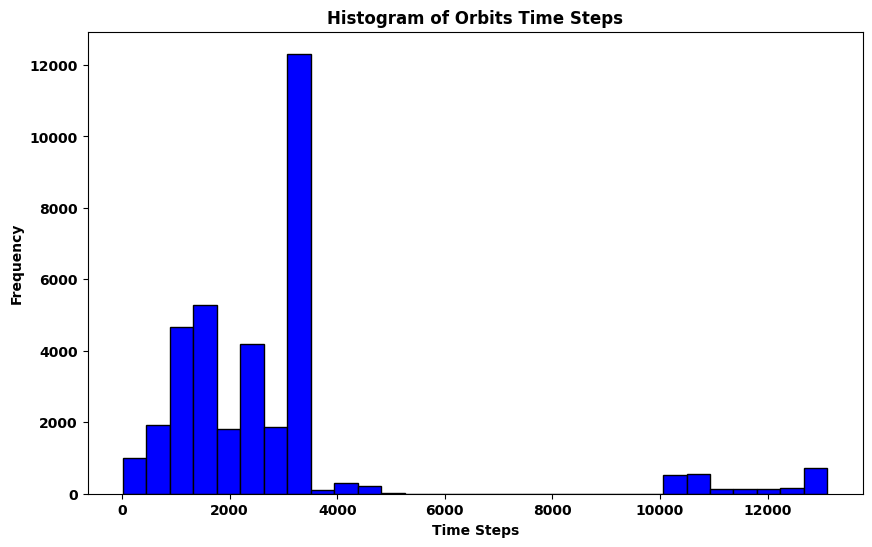

In [38]:
import matplotlib.pyplot as plt

# Assuming orbit_data is already loaded as described previously
def plot_orbit_data_lengths(orbit_data):
    lengths = []
    
    # Iterate over each dataset name from '1' to '36071'
    for key in range(1, 36072):  # range(1, 36072) because the upper limit is exclusive
        if key in orbit_data:
            lengths.append(len(orbit_data[key][0]))  # Append the length of the first dimension of the dataset
    
    # Plot the histogram of these lengths
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=30, color='blue', edgecolor='black')
    plt.title('Histogram of Orbits Time Steps')
    plt.xlabel('Time Steps')
    plt.ylabel('Frequency')
    plt.show()

plot_orbit_data_lengths(orbit_data)

In [46]:
periods = orbit_data['prop_periods'][0]

In [47]:
periods[0]

3

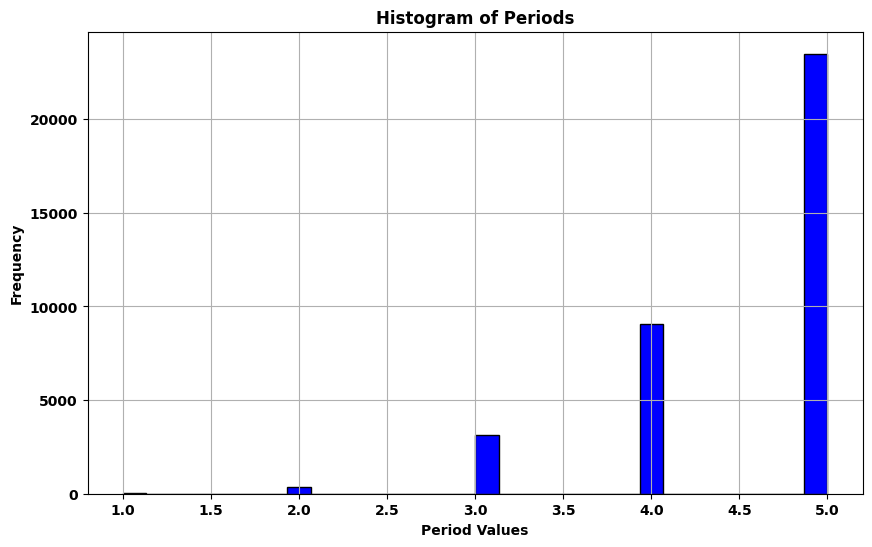

In [48]:
import matplotlib.pyplot as plt

def plot_histogram(periods):
    """
    Plot a histogram of the array 'periods'.
    
    Parameters:
        periods (list or np.ndarray): An array of integers whose distribution is to be plotted.
    """
    plt.figure(figsize=(10, 6))  # Set the figure size for the histogram
    plt.hist(periods, bins=30, color='blue', edgecolor='black')  # Plot the histogram
    plt.title('Histogram of Periods')  # Add a title to the histogram
    plt.xlabel('Period Values')  # Label the x-axis
    plt.ylabel('Frequency')  # Label the y-axis
    plt.grid(True)  # Optionally add a grid for better readability
    plt.show()  # Display the histogram

plot_histogram(periods)


In [26]:
orbit_data['prop_periods']

array([[3, 3, 3, ..., 5, 5, 5]], dtype=int8)

In [25]:
orbit_data['mu']

array(0.01215059)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()